In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler ,  StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import pickle

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
df_feat = pd.read_csv('../encoded data/opamps-features.csv')
df_ref = pd.read_csv('../encoded data/opamps-xref.csv')

In [5]:
categorical_columns = ["Supplier_Package"]
numerical_columns = ["Maximum Input Offset Voltage","Maximum Single Supply Voltage","Minimum Single Supply Voltage","Number of Channels per Chip","Typical Gain Bandwidth Product"]

In [6]:
import helper_functions.preprocess as pp

df_feat_scaled , scaler = pp.scale(df_feat,numerical_columns)
df = pp.merge_datasets(df_feat_scaled,df_ref)

In [7]:
base_means = {'A': 0.95, 'B': 0.8, 'C': 0.5, 'D': 0.3}
base_std = {'A': 0.025 / 3, 'B': 0.025 / 2.5, 'C': 0.025 / 2, 'D': 0.025 / 1.5}

In [8]:
import importlib
import helper_functions.preprocess as pp

importlib.reload(pp)
spread=0.12
df = pp.generate_y_abs(df, base_means, spread,categorical_columns ,numerical_columns)


<Axes: xlabel='Closeness', ylabel='Density'>

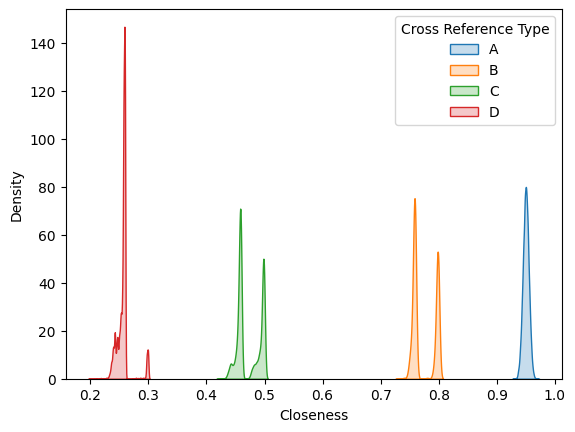

In [9]:
# df = pp.generate_closeness(df,base_means,base_std,n_std=3)
sns.kdeplot(data=df, x='Closeness', hue='Cross Reference Type', fill=True, common_norm=False)

In [10]:
# prompt: label encoder for "Supplier_Package" column of df, apply it to "Supplier_Package_comp" too

from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
le = LabelEncoder()

# Fit the encoder on the "Supplier_Package" column
le.fit(df["Supplier_Package"])

# Transform the "Supplier_Package" column
df["Supplier_Package"] = le.transform(df["Supplier_Package"])

# Apply the same encoder to the "Supplier_Package_comp" column
df["Supplier_Package_comp"] = le.transform(df["Supplier_Package_comp"])


In [14]:
# prompt: get the label => labeled from le LabelEncoder

# Get the mapping between labels and encoded values
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
label_num =dict(zip(le.classes_, le.transform(le.classes_)))
num_label = dict(zip(le.transform(le.classes_),le.classes_))

print(num_label)

{0: 'Bare Die', 1: 'CAN', 2: 'CDIP', 3: 'CDIP N', 4: 'CFLAT', 5: 'CFP', 6: 'CFPAK', 7: 'CLLCC', 8: 'CPAK', 9: 'CSOIC', 10: 'Case P-5', 11: 'Chip', 12: 'DDPAK', 13: 'DFN', 14: 'DFN EP', 15: 'DFN-U1 EP', 16: 'DFN-W1 EP', 17: 'DIP', 18: 'DMP', 19: 'DSBGA', 20: 'Die', 21: 'EMP', 22: 'EQFN-E2 EP', 23: 'ESON', 24: 'ESON-U1', 25: 'ESON-W2 EP', 26: 'ESV', 27: 'FLP', 28: 'FPACK', 29: 'Flip-Chip', 30: 'HMSOP EP', 31: 'HSOIC EP', 32: 'HSOP EP', 33: 'HTSSOP EP', 34: 'HVSOF EP', 35: 'HVSSOP EP', 36: 'LCC', 37: 'LCCC', 38: 'LFCSP', 39: 'LFCSP EP', 40: 'MFP', 41: 'MMPAK', 42: 'MPAK', 43: 'MSOP', 44: 'MSOP EP', 45: 'Metal Can', 46: 'Micro', 47: 'Mini-DIP', 48: 'Mini-PDIP', 49: 'Mini-SO', 50: 'Not Mentioned', 51: 'PCSP-C3', 52: 'PCSP-CC EP', 53: 'PCSP-E3 EP', 54: 'PDIP', 55: 'PDIP N', 56: 'PFM', 57: 'PLCC', 58: 'PSOP', 59: 'QFN', 60: 'QFN EP', 61: 'QSOP', 62: 'SBCDIP', 63: 'SC-70', 64: 'SC-74A', 65: 'SC-88A', 66: 'SIP', 67: 'SMV', 68: 'SNT-A', 69: 'SO', 70: 'SO EP', 71: 'SO N', 72: 'SO W', 73: 'SOIC', 

In [15]:
unique_labels = len(num_label)

In [16]:
df_train, df_validation, df_test = pp.split_dataframe(df)

In [17]:
df_train = pp.balance_training_data(df_train,ratios={"A": 4, "B": 3, "C": 1, "D": 2/3})
print(f"Length : {len(df_train)}")

Length : 706111


In [18]:
columns_to_drop = ['Closeness', 'MPN', "MANUFACTURER",'MPN_comp',"MANUFACTURER_comp", "Cross Reference Type"]

In [19]:
X_train = df_train.drop(columns=columns_to_drop)
X_validation = df_validation.drop(columns=columns_to_drop)
X_test = df_test.drop(columns=columns_to_drop)

y_train = df_train['Closeness']
y_validation = df_validation['Closeness']
y_test = df_test['Closeness']

In [20]:

X_train = torch.tensor(X_train.values, dtype=torch.float16)
X_validation = torch.tensor(X_validation.values, dtype=torch.float16)
X_test = torch.tensor(X_test.values, dtype=torch.float16)
y_train = torch.tensor(y_train.values, dtype=torch.float16).reshape(-1, 1)
y_validation = torch.tensor(y_validation.values, dtype=torch.float16).reshape(-1, 1)
y_test = torch.tensor(y_test.values, dtype=torch.float16).reshape(-1, 1)

In [48]:
batch_size = 4096*2

In [49]:
train_dataset = TensorDataset(X_train.cpu(), y_train.cpu())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,pin_memory=True)

val_dataset = TensorDataset(X_validation.cpu(), y_validation.cpu())
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,pin_memory=True)

test_dataset = TensorDataset(X_test.cpu(), y_test.cpu())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,pin_memory=True)

In [50]:
class SimilarityModel(nn.Module):
    """
    Simple MLP that embeds Supplier_Package of both components,
    concatenates with all numeric features (excluding those indices),
    and predicts closeness in [0,1].
    """
    def __init__(self,
                 num_total_numeric: int = 10,
                 num_categories: int =unique_labels ,
                 embed_dim: int = 8,
                 hidden_dims: list = [64, 32],
                 dropout: float = 0.1):
        super(SimilarityModel, self).__init__()
        # Embedding for the two categorical supplier_package fields
        self.embedding = nn.Embedding(num_categories, embed_dim)

        # Input dimension: all numeric features + two embeddings
        input_dim = num_total_numeric + 2 * embed_dim

        # Build a simple MLP
        layers = []
        in_dim = input_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, h_dim))
            layers.append(nn.BatchNorm1d(h_dim))
            layers.append(nn.LeakyReLU())
            layers.append(nn.Dropout(dropout))
            in_dim = h_dim
        layers.append(nn.Linear(in_dim, 1))  # output a single score
        self.mlp = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (batch_size, feature_count)
        # Extract categorical indices
        sup1 = x[:, 4].long()   # Supplier_Package for component 1
        sup2 = x[:, 10].long()  # Supplier_Package for component 2

        # Get embeddings
        emb1 = self.embedding(sup1)  # (batch, embed_dim)
        emb2 = self.embedding(sup2)  # (batch, embed_dim)

        # Extract numeric features: drop indices 4 and 10
        numeric = torch.cat((
            x[:, :4],     # features 0-3
            x[:, 5:10],   # features 5-9
            x[:, 11:]     # features 11+
        ), dim=1)        # total num_total_numeric dims

        # Concatenate numeric + both embeddings
        features = torch.cat((numeric, emb1, emb2), dim=1)

        # MLP prediction
        raw = self.mlp(features)
        return torch.sigmoid(raw)  # in [0,1]

In [51]:
model = SimilarityModel(
    embed_dim=8,
    hidden_dims=[64, 32],
    dropout=0.2
).to(device)

In [52]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

In [53]:
num_epochs = 100

In [54]:
train_losses = []
val_losses = []

In [55]:
from tqdm import tqdm

for epoch in range(1, num_epochs+1):
    model.train()
    train_loss = 0.0
    for xb, yb in tqdm(train_loader):
        xb, yb = xb.to(device).float(), yb.to(device).float()
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in tqdm(val_loader):
            xb, yb = xb.to(device).float(), yb.to(device).float()
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item() * xb.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    scheduler.step(val_loss)
    print(f"Epoch {epoch:02d}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")


100%|██████████| 7/7 [00:00<00:00,  9.07it/s]


Epoch 01: Train Loss = 0.0222, Val Loss = 0.0082


100%|██████████| 7/7 [00:00<00:00,  9.65it/s]


Epoch 02: Train Loss = 0.0144, Val Loss = 0.0084


100%|██████████| 7/7 [00:00<00:00,  9.87it/s]


Epoch 03: Train Loss = 0.0130, Val Loss = 0.0082


100%|██████████| 7/7 [00:00<00:00,  9.40it/s]


Epoch 04: Train Loss = 0.0125, Val Loss = 0.0076


100%|██████████| 7/7 [00:00<00:00,  9.74it/s]


Epoch 05: Train Loss = 0.0123, Val Loss = 0.0077


 24%|██▍       | 21/87 [00:02<00:09,  7.10it/s]


KeyboardInterrupt: 

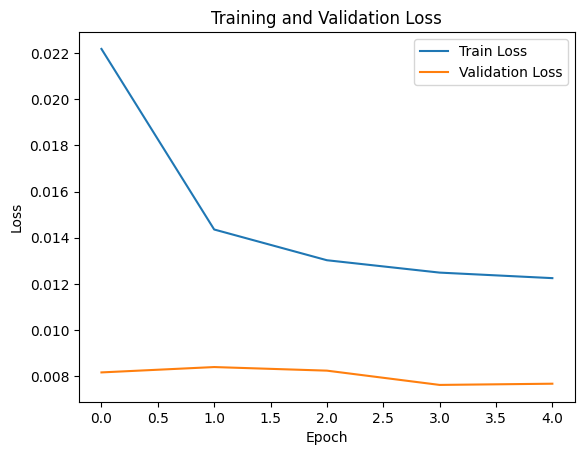

In [56]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [58]:
all_preds = []
all_targets = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device).float()
        preds = model(xb).cpu()
        
        all_preds.append(preds.flatten())
        all_targets.append(yb.flatten())
y_pred = torch.cat(all_preds).numpy()
y_true = torch.cat(all_targets).numpy()

mse_test = ((y_pred - y_true) ** 2).mean()
print(f"Test MSE: {mse_test:.6f}")

Test MSE: 0.033049


In [59]:
df_test_results = pd.DataFrame({
    'y_test': y_true.flatten(),
    'Cross Reference Type': df_test['Cross Reference Type'].values,
    'y_pred': y_pred.flatten()
})

C:\Users\adamg\AppData\Local\Temp\ipykernel_16580\3746708182.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


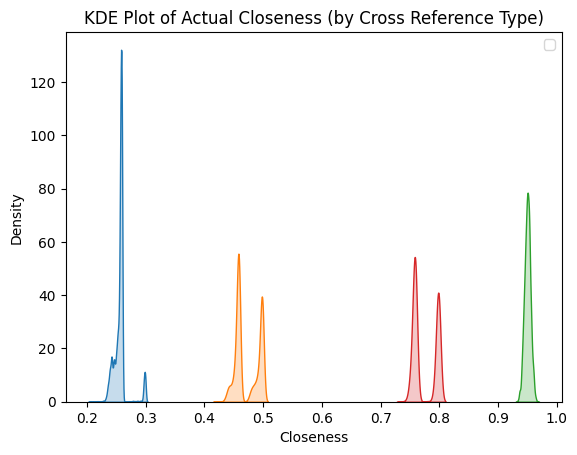

C:\Users\adamg\AppData\Local\Temp\ipykernel_16580\3746708182.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


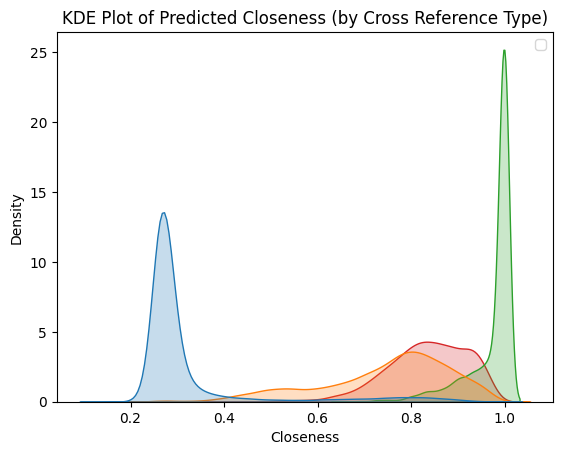

In [60]:
sns.kdeplot(
    data=df_test_results,
    x='y_test',
    hue='Cross Reference Type',
    fill=True,
    common_norm=False
)
plt.xlabel("Closeness")
plt.ylabel("Density")
plt.title("KDE Plot of Actual Closeness (by Cross Reference Type)")
plt.legend()
plt.show()

# KDE of predictions
sns.kdeplot(
    data=df_test_results,
    x='y_pred',
    hue='Cross Reference Type',
    fill=True,
    common_norm=False
)
plt.xlabel("Closeness")
plt.ylabel("Density")
plt.title("KDE Plot of Predicted Closeness (by Cross Reference Type)")
plt.legend()
plt.show()